In [1]:
import shapefile
import zipfile
import shapely
import pyproj
import pandas as pd
from shapely.geometry import LineString
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
from route2vel.route import find_route
import route2vel
from notebookutils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('dark_background')

Interpolate a single polyline obtained from a route, while trying to identify route parts.

In [4]:
graph_area = "Città Metropolitana di Bologna"

In [5]:
route2vel.load_config("../..")

In [6]:
graph = load_graph(graph_area)
graph_gdf_nodes, graph_gdf_edges = ox.graph_to_gdfs(graph)

Loading graph from d:\Documenti\Universita\tesim\route2velpy\src\graph\Città Metropolitana di Bologna.graphnx.pickle ...
Loaded in 1.41s!


In [7]:
# use two routes to make a complex route in shape, use simple pathfinding to increase
# complexity as it would tend to go on straighter roads otherwise
route1 = find_route(graph, "Ospedale Maggiore, Bologna", "Porta Santo Stefano, Bologna", weight='length')
route2 = find_route(graph, "Porta Santo Stefano, Bologna", "Bologna Fiere, Bologna", weight='length')
route_gdf: gpd.GeoDataFrame = ox.utils_graph.route_to_gdf(graph, route1[:-1] + route2, 'travel_time') # use recently added osmnx function instead of ours

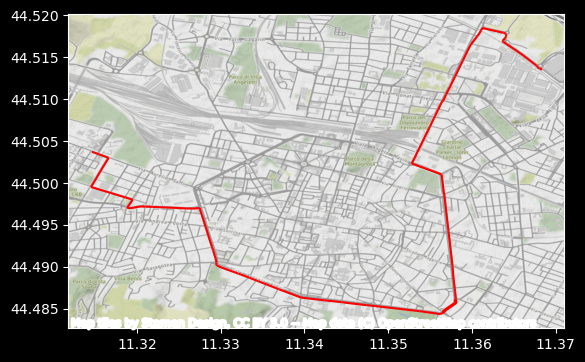

In [8]:
fig, ax = plt.subplots()
route_gdf.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, crs=route_gdf.crs)
plt.show()

LINESTRING (11.3146371 44.5037124, 11.3147509 44.5036707, 11.3149443 44.5035979, 11.3149964 44.5035773, 11.3150839 44.5035427, 11.3152814 44.5034726, 11.315415 44.5034223, 11.3154604 44.5034063, 11.315524 44.503383, 11.3156146 44.5033498, 11.3158816 44.5032519, 11.3163217 44.5030906, 11.316622 44.5029805, 11.3165678 44.5028915, 11.3160905 44.5021088, 11.3160663 44.5020692, 11.3156814 44.5014408, 11.3156261 44.5013478, 11.3150682 44.5003928, 11.3150528 44.500367, 11.3150142 44.5003101, 11.3149809 44.50025, 11.3146116 44.4996475, 11.3145246 44.4995053, 11.3145798 44.4994886, 11.3153324 44.4992606, 11.3154319 44.4992305, 11.315646 44.4991656, 11.3167986 44.4988175, 11.3169209 44.4987794, 11.3170241 44.498748, 11.3179945 44.4984494, 11.3186762 44.4982422, 11.3187935 44.4982084, 11.3189194 44.4981711, 11.319365 44.4980275, 11.3194958 44.4979868, 11.3194517 44.49792, 11.3192007 44.4975432, 11.318933 44.4971513, 11.3189032 44.4971082, 11.3188532 44.4970087, 11.3189444 44.4969901, 11.3190756 4

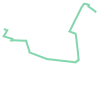

In [9]:
def remove_adjacent_duplicates(lst):
    i = 1
    while i < len(lst):
        if lst[i] == lst[i - 1]:
            del lst[i]
        else:
            i += 1
    return lst

ptlist = [pt for x in route_gdf['geometry'] for pt in x.coords]
remove_adjacent_duplicates(ptlist)
merged_route_polyline: shapely.LineString = shapely.LineString(ptlist)
print(merged_route_polyline)
merged_route_polyline

In [10]:
from typing import Callable
from shapely import Point

def coord_distance_meters(coords1:tuple, coords2:tuple, lon_first=True):
    """Convert coord distance to meters. Make sure to use WGS-84 coordinates.
    """
    if lon_first:
        coords1 = coords1[::-1]
        coords2 = coords2[::-1]

    return ox.distance.great_circle_vec(*coords1, *coords2)

def split_linestring_by_curves(linestring: LineString, distance_treshold: float, 
                                distance_func: Callable[[tuple, tuple, bool], float] = coord_distance_meters,
                                lon_first=True,
                                add_borders_as_new_group_first=True,
                                return_labels=True,
                                return_geoseries=False,
                                ) -> "list[dict|(LineString|Point)]":
    result = []
    labels = []
    current_group = [linestring.coords[0]]
    group_under_treshold = None
    for prev_point, current_point in zip(linestring.coords[:-1], linestring.coords[1:]):
        distance = distance_func(prev_point, current_point, lon_first)
        
        cur_under_treshold = distance <= distance_treshold
        if group_under_treshold is None:
            group_under_treshold = cur_under_treshold

        if cur_under_treshold == group_under_treshold:
            current_group.append(current_point)
        else:
            if len(current_group) > 1:
                result.append(LineString(current_group))
            else:
                result.append(Point(current_group[0]))
            labels.append(group_under_treshold)

            group_under_treshold = not group_under_treshold
            if add_borders_as_new_group_first:
                current_group = [prev_point, current_point]
            else:
                current_group = [current_point]
    
    if len(current_group) > 1:
        result.append(LineString(current_group))
    else:
        result.append(Point(current_group[0]))
    labels.append(group_under_treshold)

    if return_geoseries:
        result = gpd.GeoSeries(result)

    if return_labels:
        return result, labels
    else:
        return result

In [11]:
# test
test_linestring = LineString([(x, 0) for x in (0, 1, 3, 4, 5, 5.5, 10, 13, 14)])
split_linestring_by_curves(test_linestring, 1, lambda x, y, _: abs(y[0] - x[0]), return_geoseries=False)

([<LINESTRING (0 0, 1 0)>,
  <LINESTRING (1 0, 3 0)>,
  <LINESTRING (3 0, 4 0, 5 0, 5.5 0)>,
  <LINESTRING (5.5 0, 10 0, 13 0)>,
  <LINESTRING (13 0, 14 0)>],
 [True, False, True, False, True])

,geometry,curve
0,"LINESTRING (11.31464 44.50371, 11.31475 44.503...",straight
1,"LINESTRING (11.31494 44.50360, 11.31500 44.503...",curve
2,"LINESTRING (11.31508 44.50354, 11.31528 44.503...",straight
3,"LINESTRING (11.31541 44.50342, 11.31546 44.503...",curve
4,"LINESTRING (11.31561 44.50335, 11.31588 44.503...",straight
...,...,...
108,"LINESTRING (11.36371 44.51683, 11.36410 44.516...",straight
109,"LINESTRING (11.36611 44.51521, 11.36612 44.51520)",curve
110,"LINESTRING (11.36612 44.51520, 11.36647 44.514...",straight
111,"LINESTRING (11.36785 44.51385, 11.36787 44.513...",curve


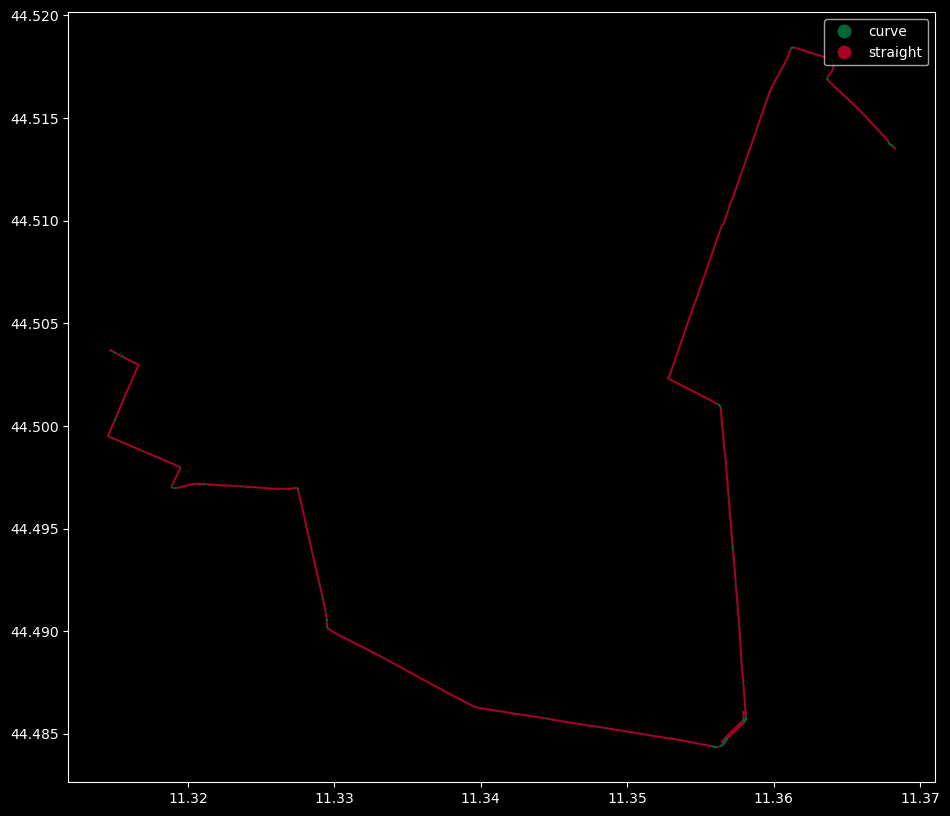

In [12]:
dist_treshold = 10
linestrings, curve_labels = split_linestring_by_curves(merged_route_polyline, dist_treshold)

def line_avg_dist(line: LineString):
    return sum([coord_distance_meters(cur, next) for cur, next in zip(line.coords[:-1], line.coords[1:])]) / (len(line.coords) - 1)

split_density_gdf = gpd.GeoDataFrame({
    'geometry': linestrings,
    'curve': ['curve' if x else 'straight' for x in curve_labels],
}, geometry='geometry', crs=graph_gdf_edges.crs)
split_density_gdf.plot('curve', categorical=True, legend=True, cmap='RdYlGn_r', figsize=(15,10))
display(split_density_gdf)

In [19]:
def get_utm_zone(lon, lat):
    zone = int((lon + 180) / 6) + 1
    return zone
points_average = np.array([line.centroid.coords[0] for line in split_density_gdf.geometry]).mean(axis=0)
meters_utm_zone = get_utm_zone(points_average[0], points_average[1])
meters_utm_zone

32

In [24]:
from pyproj import Transformer, CRS
from shapely.ops import transform

input_crs: CRS = split_density_gdf.crs
target_crs = CRS(proj='utm', zone=meters_utm_zone, units="m", ellipsis=input_crs.datum.ellipsoid)
transformer = Transformer.from_crs(input_crs, target_crs, always_xy=True)

In [29]:
geometry_in_meters = [transform(transformer.transform, line) for line in split_density_gdf.geometry]
geometry_in_meters[:5]

[<LINESTRING (683997.707 4930427.416, 684006.885 4930423.04, 684022.488 49304...>,
 <LINESTRING (684022.488 4930415.389, 684026.694 4930413.218, 684033.759 4930...>,
 <LINESTRING (684033.759 4930409.572, 684049.68 4930402.23, 684060.459 493039...>,
 <LINESTRING (684060.459 4930396.944, 684064.118 4930395.269, 684069.247 4930...>,
 <LINESTRING (684076.554 4930389.34, 684098.087 4930379.067, 684133.581 49303...>]

In [30]:
split_density_gdf['length'] = [line.length for line in geometry_in_meters]
split_density_gdf

,geometry,curve,length
0,"LINESTRING (11.31464 44.50371, 11.31475 44.503...",straight,27.545523
1,"LINESTRING (11.31494 44.50360, 11.31500 44.503...",curve,12.683735
2,"LINESTRING (11.31508 44.50354, 11.31528 44.503...",straight,29.537323
3,"LINESTRING (11.31541 44.50342, 11.31546 44.503...",curve,17.801313
4,"LINESTRING (11.31561 44.50335, 11.31588 44.503...",straight,195.701555
...,...,...,...
108,"LINESTRING (11.36371 44.51683, 11.36410 44.516...",straight,261.957049
109,"LINESTRING (11.36611 44.51521, 11.36612 44.51520)",curve,1.052850
110,"LINESTRING (11.36612 44.51520, 11.36647 44.514...",straight,204.282030
111,"LINESTRING (11.36785 44.51385, 11.36787 44.513...",curve,36.235129


In [34]:
split_density_gdf.groupby('curve').describe()

length                                                            \
          count        mean         std        min        25%         50%   
curve                                                                       
curve      56.0   13.975770   12.242388   1.052850   6.928092    9.232486   
straight   57.0  167.915572  194.817060  10.079704  61.352425  123.295310   

                                   
                 75%          max  
curve                              
curve      17.448512    67.360756  
straight  200.021595  1053.159747

In [ ]:
from route2vel.interp import merge_short_segments

In [ ]:
merge_short_segments(split_density_gdf.geometry, split_density_gdf.)